# Find a localised dark matter halo along with the source
### Fit pixelated lens potential perturbations and a pixelated source, assuming a known SIE model

__last update__: 28/07/21 (not compatible with latest updates!)

In [1]:
# Basic imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import ndimage
%matplotlib inline
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import optax

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
# True source model
true_source_light_model_list = ['SERSIC_ELLIPSE']
true_source_light_model = LightModel(true_source_light_model_list)
kwargs_true_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

# Pixelated source model
pixel_source_light_model_list = ['PIXELATED']
pixel_source_light_model = LightModel(pixel_source_light_model_list)

### Lens models (large-scale SIE + an SIE perturber)

In [4]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'SIE']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'theta_E': 0.25, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'PIXELATED']
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list)

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF
Ignore the PSF for now.

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
# Noise
exp_time = None
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Image model

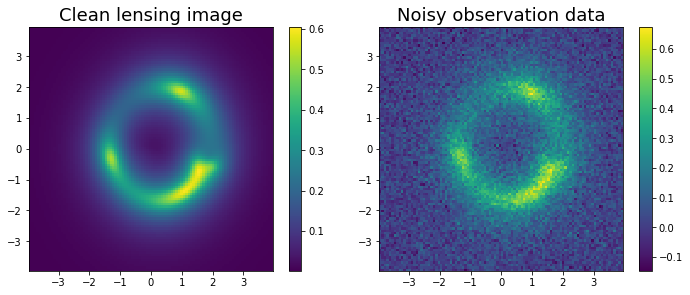

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf,
                       noise_class=noise,
                         lens_model_class=true_lens_mass_model,
                         source_model_class=true_source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_true_source_light,
                          kwargs_lens_light=kwargs_lens_light)


# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_true_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

#### Check hybrid / pxielated model interpolations

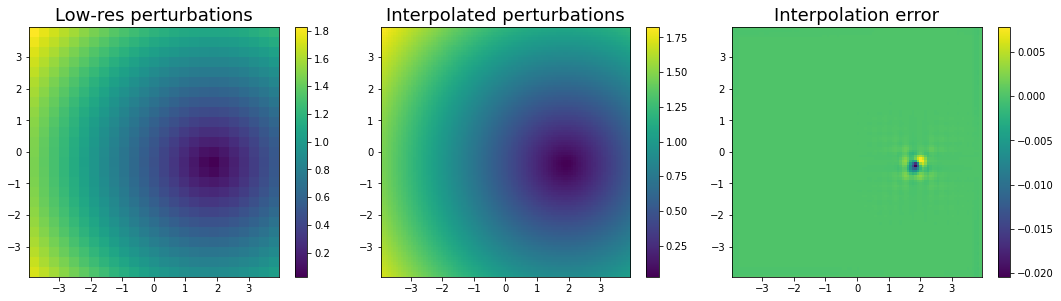

In [8]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],
                           {'x_coords': x_coords_lowres, 
                            'y_coords': y_coords_lowres, 
                            'psi_grid': psi_grid_true_lowres}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass, k=1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

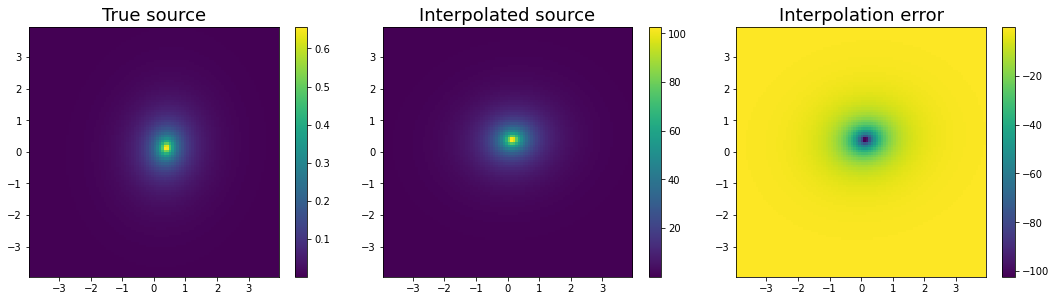

In [9]:
# Extract the true source profile on original grid
source_true = lens_image.source_surface_brightness(kwargs_source=kwargs_true_source_light,
                                                   de_lensed=True, unconvolved=True)

# Set the hybrid lens mass model parameters
kwargs_pixel_source_light = [{'x_coords': jnp.asarray(x_coords), 
                              'y_coords': jnp.asarray(y_coords), 
                              'image': jnp.asarray(source_true)}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
source_interp = pixel_source_light_model.surface_brightness(x_grid, y_grid, kwargs_pixel_source_light)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(source_true, origin='lower', extent=extent)
axes[0].set_title("True source", fontsize=FS)
img2 = axes[1].imshow(source_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated source", fontsize=FS)
img3 = axes[2].imshow(source_true - source_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Fitting with wavelets regularization

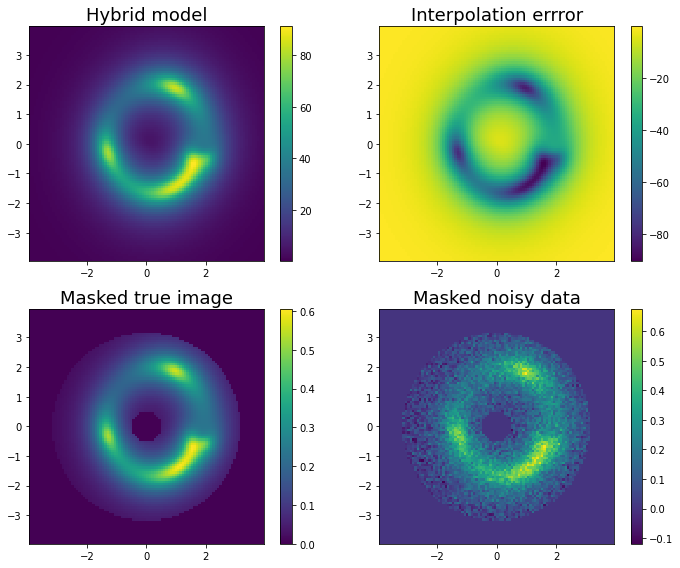

In [10]:
# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=pixel_source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Test the hybrid model with the true low-res perturbation grid
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_pixel_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### Parameters

Here we select which parameters to optimise, which one are fixed, lower/upper bounds (treated as "uniform" prior).

In [11]:
masked_lower = -10.*np.ones(npix_lowres**2)*mask_lowres.flatten()
masked_upper = +10.*np.ones(npix_lowres**2)*mask_lowres.flatten()

kwargs_model = {
    'lens_model_list': hybrid_lens_mass_model_list,
    'source_model_list': pixel_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {'psi_grid': 1e-8 * jnp.ones((npix_lowres, npix_lowres))}],
    #'kwargs_lens': [{}, {'psi_grid': jnp.array(psi_grid_true_lowres)}],
    #'kwargs_source': [{'image': 1e-8 * jnp.ones((npix, npix))}],
    'kwargs_source': [{'image': jnp.array(source_true)}],
}
kwargs_prior = {
    #'kwargs_lens': [{}, {}],
    #'kwargs_lens': [{}, {'psi_grid': ['uniform', -np.inf, +np.inf]}],
    'kwargs_lens': [{}, {'psi_grid': ['uniform', masked_lower, masked_upper]}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [kwargs_hybrid_lens_mass[0], {'x_coords': x_coords_lowres, 'y_coords': y_coords_lowres}],
    #'kwargs_lens': [kwargs_hybrid_lens_mass[0], {'psi_grid': psi_grid_true_lowres, 'x_coords': x_coords_lowres, 'y_coords': y_coords_lowres}],
    'kwargs_source': [{'x_coords': x_coords, 'y_coords': y_coords}],
    #'kwargs_source': [{'image': source_true.T, 'x_coords': x_coords, 'y_coords': y_coords}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {
    'kwargs_lens': kwargs_hybrid_lens_mass, 
    'kwargs_source': kwargs_pixel_source_light,
}
p_init = parameters.kwargs2args(kwargs_init)
p_true = parameters.kwargs2args(kwargs_true)
print("truths:", len(p_true), parameters.names[0])

print(parameters.prior_types[0])
#print(parameters.bounds)

truths: 10625 dpsi_0
uniform


#### Initial maps

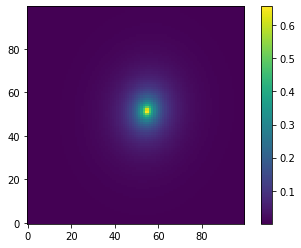

In [12]:
#plt.imshow(kwargs_init['kwargs_lens'][1]['psi_grid'].reshape(npix_lowres, npix_lowres), origin='lower')
plt.imshow(kwargs_init['kwargs_source'][0]['image'].reshape(npix, npix), origin='lower')
plt.colorbar()
plt.show()

#### Bounds for $\delta\psi$

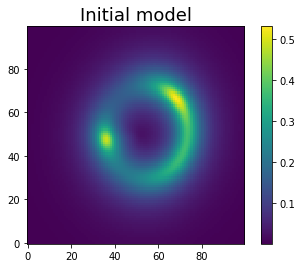

In [13]:
hybrid_image_init = hybrid_lens_image.model(**parameters.args2kwargs(p_init))

#plt.title("Initial residuals", fontsize=FS)
#plt.imshow((data - hybrid_image_init) / np.sqrt(lens_image.Noise.C_D), origin='lower', cmap='bwr', vmin=-4, vmax=4)
plt.title("Initial model", fontsize=FS)
plt.imshow(hybrid_image_init, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

In [14]:
def plot_pixelated_potential_result(optimizer, kwargs_f, shift_potential='min', with_mask=True):
    if optimizer is not None:
        fig, ax = plt.subplots(1, 1)
        ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
        ax.set_ylabel("Loss", fontsize=FS)
        ax.set_xlabel("Iteration", fontsize=FS)
        plt.show()
        
    # create the resulting model image
    rec_image = hybrid_lens_image.model(**kwargs_f)
    noise_var = lens_image.Noise.C_D
    alpha_x, alpha_y = hybrid_lens_image.LensModel.alpha(x_grid_lowres, y_grid_lowres, kwargs_f['kwargs_lens'], k=1)
    kappa = hybrid_lens_image.LensModel.kappa(x_grid_lowres, y_grid_lowres, kwargs_f['kwargs_lens'], k=1)

    # Reshape the final psi grid
    psi_grid_rec = kwargs_f['kwargs_lens'][1]['psi_grid']
    if shift_potential == 'min':
        min_in_mask = (psi_grid_rec * mask_lowres).min()
        psi_grid_rec = psi_grid_rec - min_in_mask
        print("delta_psi shift by min:", min_in_mask)
    elif shift_potential == 'mean':
        mean_in_mask = (psi_grid_rec * mask_lowres).mean()
        true_mean_in_mask = (psi_grid_true_lowres * mask_lowres).mean()
        psi_grid_rec = psi_grid_rec - mean_in_mask + true_mean_in_mask
        print("delta_psi shift & normalization by mean:", mean_in_mask, true_mean_in_mask)
        
    # source images
    rec_source = kwargs_f['kwargs_source'][0]['image']
        
    fig, axes = plt.subplots(4, 3, figsize=(15, 18))
    ax = axes[0, 0]
    img = ax.imshow(data, origin='lower', extent=extent)
    ax.set_title("Data", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[0, 1]
    img = ax.imshow(rec_image, origin='lower', extent=extent)
    ax.set_title("Image reconstruction", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[0, 2]
    img = ax.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', cmap='RdBu_r', vmin=-4, vmax=4, extent=extent)
    ax.set_title("Normalised residuals", fontsize=FS)
    ax.set_xlabel(f"Chi-sq : {np.mean((data - rec_image)**2 / noise_var):.2f}")
    fig.colorbar(img, ax=ax)

    ax = axes[1, 0]
    psi_grid_true_show = psi_grid_true_lowres
    if with_mask:
        psi_grid_true_show *= mask_lowres
    img = ax.imshow(psi_grid_true_show, origin='lower', extent=extent)
    ax.set_title("True $\delta\psi$", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[1, 1]
    psi_grid_rec_show = psi_grid_rec
    if with_mask:
        psi_grid_rec_show *= mask_lowres
    img = ax.imshow(psi_grid_rec_show, origin='lower', extent=extent)
    ax.set_title("Reconstructed $\delta\psi$", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[1, 2]
    abs_res_show = (psi_grid_true_lowres - psi_grid_rec)
    if with_mask:
        abs_res_show *= mask_lowres
    vmax = 0.5 * np.max(np.abs(psi_grid_true_lowres))
    img = ax.imshow(abs_res_show, origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax, extent=extent)
    ax.set_title("Absolute residuals", fontsize=FS)
    fig.colorbar(img, ax=ax)

    ax = axes[2, 0]
    alpha_x_rec_show = alpha_x
    if with_mask:
        alpha_x_rec_show *= mask_lowres
    ax.set_title(r"$\delta\alpha_x$", fontsize=FS)
    im = ax.imshow(alpha_x_rec_show, origin='lower', alpha=1, extent=extent)
    fig.colorbar(im, ax=ax)
    ax = axes[2, 1]
    alpha_y_rec_show = alpha_y
    if with_mask:
        alpha_y_rec_show *= mask_lowres
    ax.set_title(r"$\delta\alpha_y$", fontsize=FS)
    im = ax.imshow(alpha_y_rec_show, origin='lower', alpha=1, extent=extent)
    fig.colorbar(im, ax=ax)
    ax = axes[2, 2]
    #kappa_rec_show = kappa
    kappa_rec_show = ndimage.gaussian_filter(kappa, 1)
    if with_mask:
        kappa_rec_show *= mask_lowres
    ax.set_title(r"$\delta\kappa$ (smoothed)", fontsize=FS)
    im = ax.imshow(kappa_rec_show, origin='lower', cmap='inferno', alpha=1, extent=extent, vmin=0)
    fig.colorbar(im, ax=ax)
    
    ax = axes[3, 0]
    img = ax.imshow(source_true, origin='lower')
    ax.set_title("True source", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[3, 1]
    img = ax.imshow(rec_source, origin='lower')
    ax.set_title("Reconstructed source", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[3, 2]
    img = ax.imshow(source_true - rec_source, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
    ax.set_title("Absolute residual", fontsize=FS)
    fig.colorbar(img, ax=ax)
    
    plt.show()

#### Load pre-estimated potential noise map

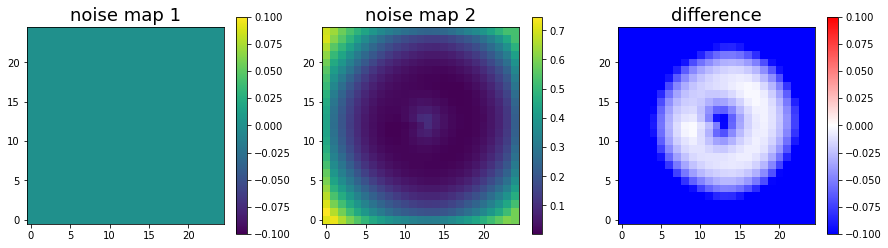

mean level: 0.17960860000000017
mean level within mask: 0.04246060739436622


In [15]:
dpsi_noise_map1 = np.zeros((npix_lowres, npix_lowres)) # np.load(f'data/dpsi_1sigma_bkg{sigma_bkd}_{npix_lowres}px_pixmass.npy')
dpsi_noise_map2 = np.load(f'data/dpsi_1sigma_bkg{sigma_bkd}_{npix_lowres}px_fullmass_fullamp.npy')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("noise map 1", fontsize=FS)
im = ax.imshow(dpsi_noise_map1, origin='lower')
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("noise map 2", fontsize=FS)
im = ax.imshow(dpsi_noise_map2, origin='lower')
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("difference", fontsize=FS)
im = ax.imshow(dpsi_noise_map1 - dpsi_noise_map2, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()

print("mean level:", np.mean(dpsi_noise_map2))
print("mean level within mask:", np.mean(dpsi_noise_map2[mask_lowres == 1.]))

### Create the loss function, including $\ell_1$-norm + starlet regularization

In [18]:
# choose potential noise map
dpsi_noise_map = np.mean(dpsi_noise_map2[mask_lowres == 1.])
#dpsi_noise_map = dpsi_noise_map2

# Create loss
loss = Loss(data, hybrid_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source',
                                  'l1_starlet_potential', 
                                  'l1_battle_potential'], 
            regularization_strengths=[(5, 3), 10, 5, (5, 3), 10],
            potential_noise_map=dpsi_noise_map)

print("Loss at init:", loss(p_init))
print("Loss at true:", loss(p_true))

Loss at init: 2.184954312588493
Loss at true: 1.372171596901542


### Optimize using `optax` gradient descent

In [19]:
# jit the gradient of the loss function
grad_loss = jax.jit(jax.grad(loss))

# Max number of iterations
n_iter = 100

# Global learning rate (or initial value when decaying)
learning_rate = 1e-2

# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=learning_rate, 
    transition_steps=n_iter,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`
optimizer_custom = optax.chain(
    #optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm
    optax.scale_by_belief(),  # Use the updates from an optimizer
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler
    optax.scale(-1.)  # because gradient *descent*
)

params = jnp.array(p_init)
opt_state = optimizer_custom.init(params)

start_time = time()

@jax.jit
def positivity(x):
    return jnp.maximum(0, x)

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_custom.update(grad_loss(params), opt_state, params)
    params = optax.apply_updates(params, updates)

print(f"Runtime: {time()-start_time:.2f} s")

p_final_optax = params
print(f"Final loss : {loss(p_final_optax):.2f}")

Runtime: 11.19 s
Final loss : 1.61


delta_psi shift by min: -0.13995914923034933


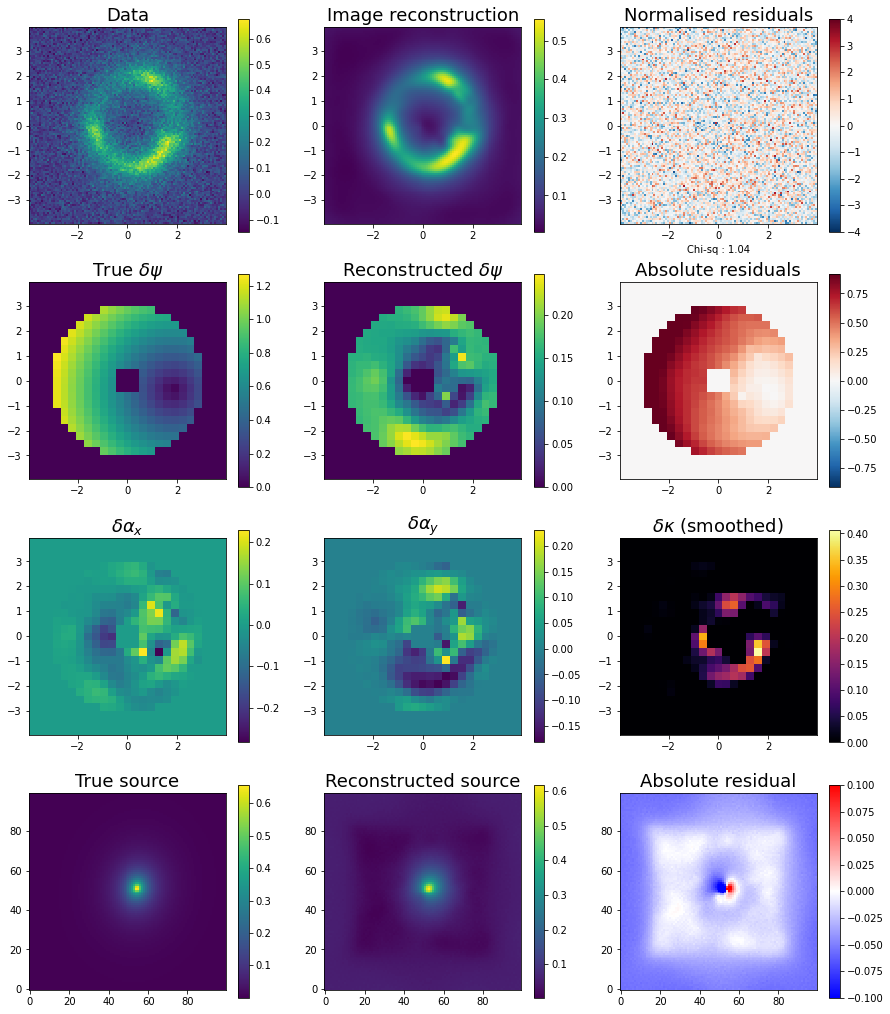

In [20]:
kwargs_final_optax = parameters.args2kwargs(p_final_optax)
plot_pixelated_potential_result(None, kwargs_final_optax, with_mask=True)